In [1]:
using CausalForest
using StatsBase
using Plots
using Random
using Distributions
using RCall
using BenchmarkTools
using DelimitedFiles

In [2]:
Random.seed!(123);
n, m = 10^4, 10;
u = Uniform(0,10);
features = rand(u, (n, m));
X = features;
d = Normal();
eps = rand(d, n);
b = Bernoulli();
T = convert(Vector{Int64},rand(b, n));
Y = sin.(features*[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]).*T  + cos.(features*[0, 0, 2, 0, 0, 0, 3, 0, 0, 0]);


In [3]:
df = hcat(X,T,Y)

10000×12 Matrix{Float64}:
 9.063     0.273863  9.2398     5.83606   …  8.61508   1.0   0.925883
 4.43494   8.65398   4.38668    8.66793      5.79587   0.0  -0.68458
 7.45673   7.98071   9.35901    5.96536      9.99516   0.0  -0.724428
 5.12083   8.25448   8.79223    2.87236      8.06585   0.0   0.943837
 2.53849   5.30423   5.84012    9.7704       9.6668    0.0  -0.782951
 3.34152   2.66141   9.8669     9.76664   …  9.49805   1.0   0.783425
 4.27328   8.75436   0.0258112  0.863643     2.24987   1.0  -1.817
 8.67547   7.27313   0.151025   4.99536      0.765286  0.0   0.995451
 0.991336  1.20752   5.87184    3.17045      9.81301   0.0  -0.386758
 1.25287   6.88003   3.64868    5.80333      3.00126   0.0   0.431152
 6.92209   0.298644  4.84843    8.11503   …  1.49476   0.0   0.288635
 1.36551   1.07227   0.570038   1.05282      7.60498   1.0   0.440009
 0.320967  6.45858   4.85281    2.0843       1.98433   0.0   0.288252
 ⋮                                        ⋱            ⋮    
 1.4147

In [4]:
header = ["X1" "X2" "X3" "X4" "X5" "X6" "X7" "X8" "X9" "X10" "T" "Y"]
writedlm("sinus_causal_6.csv", [header ; df], ",")

In [5]:
reval("set.seed(1)")
Xtest_1 = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
true_effect_1 = sin.(Xtest_1[:, 1]);

In [6]:
function get_all_nodes_in_tree!(
    tree ,
    result  = []
    )
    if hasproperty(tree, :featid)  
        push!(result, tree.featid)
        get_all_nodes_in_tree!(tree.left, result)
        get_all_nodes_in_tree!(tree.right, result)
    end
    return result
end

function get_freq(forest) 
    ensemble = forest.trees
    n_trees = length(ensemble)
    res = []
    for i = 1:n_trees
        append!(res, get_all_nodes_in_tree!(forest.trees[i].tree))
    end
    return proportionmap(res)
end

get_freq (generic function with 1 method)

# Critère nouveau

### Subsampling

In [7]:
errors_11 = zeros(100)

cf = @btime build_forest_3_opti(false, false, true, Y, T, X, true, 10, 500, 0.5, 0.5, -1, 5, 10, 2000)
pred = @btime apply_forest_3(cf, Xtest_1)
errors_11[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest_3(cf, Xtest)
    true_effect = sin.(Xtest[:, 1])
    errors_11[i] = rmsd(float(true_effect), pred)
end
print(mean(errors_11))
print(var(errors_11))

Erreur du modèle préliminaire
0.48399258948555113
Erreur du modèle préliminaire
0.4843030621643951
Erreur du modèle préliminaire
0.48406835910264623
Erreur du modèle préliminaire
0.4837725571805608
  43.424 s (9185269 allocations: 2.53 GiB)
  4.062 s (128341821 allocations: 2.37 GiB)
0.10444852669906925.871695366323365e-6

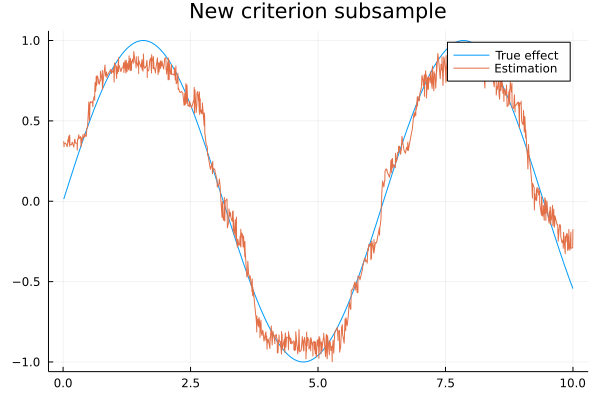

In [8]:
ind = sortperm(Xtest_1[:, 1])
pred = apply_forest_3(cf, Xtest_1)
plot(Xtest_1[ind, 1], [true_effect_1[ind], pred[ind]], label=["True effect" "Estimation"], title = "New criterion subsample", fmt = :png)

In [9]:
cf = build_forest_3_opti(false, false, true, Y, T, X, true, 10, 500, 0.5, 0.5, -1, 5, 10, 2000)

get_freq(cf)

Erreur du modèle préliminaire
0.48382899566251386


Dict{Any, Float64} with 10 entries:
  5  => 0.0957884
  4  => 0.0936415
  6  => 0.0940954
  7  => 0.093617
  2  => 0.0960951
  10 => 0.0942426
  9  => 0.0920835
  8  => 0.0967944
  3  => 0.0955553
  1  => 0.148087

Avec le mtry différent de max

In [13]:
errors_11 = zeros(100)

cf = @btime build_forest_3_opti(false, false, true, Y, T, X, false, -1, 500, 0.7, 0.5, -1, 5, 10, 2000)
pred = @btime apply_forest_3(cf, Xtest_1)
errors_11[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest_3(cf, Xtest)
    true_effect = sin.(Xtest[:, 1])
    errors_11[i] = rmsd(float(true_effect), pred)
end
print(mean(errors_11))
print(var(errors_11))

Erreur du modèle préliminaire
0.483876722952995
Erreur du modèle préliminaire
0.48418759196680594
Erreur du modèle préliminaire
0.48437742874612577
Erreur du modèle préliminaire
0.48413479332608467
  42.643 s (10076709 allocations: 2.67 GiB)
  3.962 s (128309326 allocations: 2.37 GiB)
0.105309386821312415.543584069155379e-6

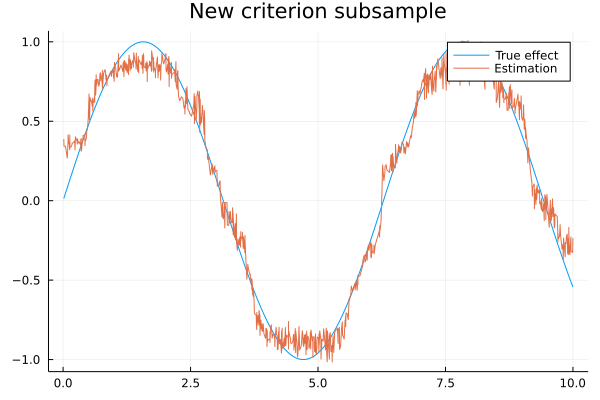

In [14]:
ind = sortperm(Xtest_1[:, 1])
pred = apply_forest_3(cf, Xtest_1)
plot(Xtest_1[ind, 1], [true_effect_1[ind], pred[ind]], label=["True effect" "Estimation"], title = "New criterion subsample", fmt = :png)

In [17]:
errors_11 = zeros(100)

cf = @btime build_forest_3_opti(false, false, true, Y, T, X, false, -1, 500)
pred = @btime apply_forest_3(cf, Xtest_1)
errors_11[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest_3(cf, Xtest)
    true_effect = sin.(Xtest[:, 1])
    errors_11[i] = rmsd(float(true_effect), pred)
end
print(mean(errors_11))
print(var(errors_11))

Erreur du modèle préliminaire
0.4857865973930974
Erreur du modèle préliminaire
0.4866488644327106
Erreur du modèle préliminaire
0.4872274772950262
Erreur du modèle préliminaire
0.48655535267766625
  8.531 s (3513627 allocations: 1.01 GiB)
  3.902 s (128429722 allocations: 2.38 GiB)
0.106401577614596956.2099722066330225e-6

### Bootstrap

In [10]:
errors_12 = zeros(100)

cf = @btime build_forest_3_opti(false, true, true, Y, T, X, true, 10, 500, 0.5, 0.5, -1, 5, 10, 2000)
pred = @btime apply_forest_3(cf, Xtest_1)
errors_12[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest_3(cf, Xtest)
    true_effect = sin.(Xtest[:, 1])
    errors_12[i] = rmsd(float(true_effect), pred)
end
print(mean(errors_12))
print(var(errors_12))

Erreur du modèle préliminaire
0.484247046142355
Erreur du modèle préliminaire
0.4839214002764226
Erreur du modèle préliminaire
0.48391873945625374
Erreur du modèle préliminaire
0.4839435443707208
  53.748 s (11239451 allocations: 2.86 GiB)
  4.467 s (137613454 allocations: 2.51 GiB)
0.106389419971378175.826540997110168e-6

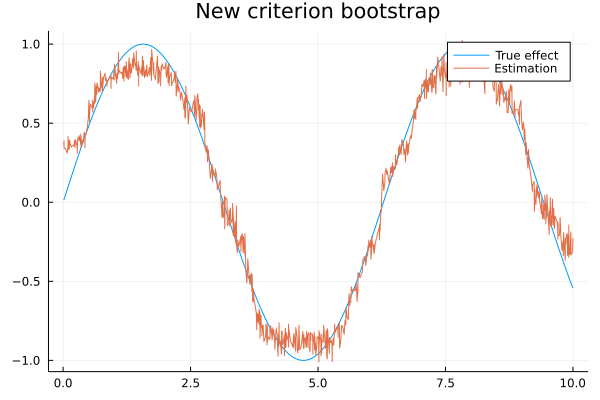

In [11]:
ind = sortperm(Xtest_1[:, 1])
pred = apply_forest_3(cf, Xtest_1)
plot(Xtest_1[ind, 1], [true_effect_1[ind], pred[ind]], label=["True effect" "Estimation"], title = "New criterion bootstrap", fmt = :png)

In [12]:
cf = build_forest_3_opti(false, true, true, Y, T, X, true, 10, 500, 0.5, 0.5, -1, 5, 10, 2000)

get_freq(cf)

Erreur du modèle préliminaire
0.4838719815917427


Dict{Any, Float64} with 10 entries:
  5  => 0.097692
  4  => 0.0964663
  6  => 0.0966338
  7  => 0.0968749
  2  => 0.0975714
  10 => 0.0980604
  9  => 0.0967342
  8  => 0.0956961
  3  => 0.0971629
  1  => 0.127108